# Fake PTA tutorial

Fake PTA is a tool for basic Pulsar Timing Array (PTA) simulations designed to work with ENTERPRISE (https://github.com/nanograv/enterprise). It copies the main features of the Pulsar object in ENTERPRISE while allowing complete modification of its attributes, making it easier to play with pulsar properties. This tool allows to simulate pulsar post-fit timing residuals (timing model is not taken into account, for this, see libstempo at https://github.com/vallis/libstempo). In its current version, it simulates white noise (EFAC, EQUAD, ECORR), red noise (RN), dispersion measure (DM) noise, scattering variation (Sv) chromatic noise and common red noises correlated between pulsars with various overlap reduction functions (Hellings-Down, monopole, dipole), as well as deterministic continuous gravitational wave (CGW) signals. Because the pulsar residuals are openly accessible, it is easy to inject any type of custom signal.

# Getting started

In [14]:
from fakepta import fake_pta
from fakepta.fake_pta import Pulsar, copy_array, make_fake_array
from fakepta.correlated_noises import add_correlated_red_noise_gp

The `Pulsar` class contains the attributes of the `Pulsar` class in ENTERPRISE that are essential to build noise and signal models. It is possible to generate an array of `Pulsar` instances using the function `make_fake_array` taking as input :

- npsrs : the number of pulsars in the array
- Tobs : observation time for each pulsar (in years)
- ntoas : number of TOAs for each pulsars
- isotropic : if True, pulsars are isotropically distributed in the sky, if False, randomly distributed
- gaps : if True, pulsars will have unevenly sampled TOAs, if False, evenly sampled TOAs
- toaerr : measurement error for every TOA (in seconds)
- pdist : pulsar distance (in kiloparsec)
- freqs : list of the various frequency bands of radio observations (in Mhz)
- backends : list of backend names
- gp_noises : if True, the noises are injected with the "fakepta.Pulsar.add_time_correlated_noise_gp" method, if False, with "fakepta.Pulsar.add_time_correlated_noise"
- noisedict : dictionnary of ENTERPRISE noise parameter values with format {"parameter_name":value}, if None, parameter values will be randomised
- custom_models : dictionnary containing the number of frequency bins for red noise (RN), dispersion measure noise (DM) and scattering variation (Sv) for injection
                    with format {"psrname":{"RN":nfbin_rn, "DM":nfbin_dm, "Sv":nfbin_sv}}, if "nfbin" set to None, no noise is added.
                    If "custom_models=None", noise model will be {"RN":30, "DM":100, "Sv":None} for all pulsars

Creating psr J0724+7374
Creating psr J2214+6164
Creating psr J1304+5313
Creating psr J0354+4605
Creating psr J1844+3979
Creating psr J0934+3406
Creating psr J0024+2869
Creating psr J1514+2358
Creating psr J0604+1866
Creating psr J2054+1389
Creating psr J1144+0921
Creating psr J0234+0459
Creating psr J1724+0000
Creating psr J0814-0459
Creating psr J2304-0921
Creating psr J1354-1389
Creating psr J0444-1866
Creating psr J1934-2358
Creating psr J1024-2869
Creating psr J0114-3406
Creating psr J1604-3979
Creating psr J0654-4605
Creating psr J2144-5313
Creating psr J1234-6164
Creating psr J0324-7374


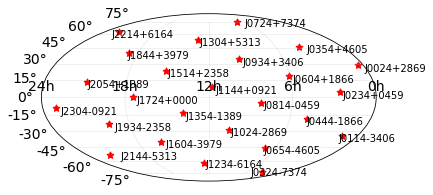

In [15]:
import matplotlib.pyplot as plt
from fakepta.fake_pta import plot_pta

psrs = make_fake_array(npsrs=25, Tobs=10, ntoas=1000, isotropic=True, gaps=True, toaerr=10**(-6), pdist=1., freqs=[1400.], backends='NUPPI', gp_noises=True, noisedict=None, custom_models=None)
plot_pta(psrs)

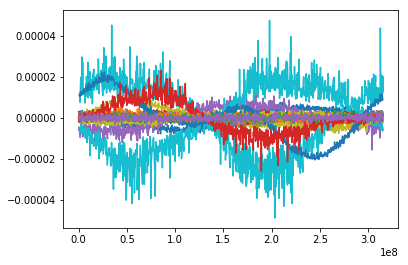

In [17]:
for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

# Copy an existing array

Use the function `copy_array` to copy an already existing pickle file of ENTERPRISE `Pulsar` objects, together with the dictionnary of ENTERPRISE noise parameter values with format {"parameter_name":value} and a dictionnary containing the number of frequency bins for red noise (RN), dispersion measure noise (DM) and scattering variation (Sv) for injection with format {"psrname":{"RN":nfbin_rn, "DM":nfbin_dm, "Sv":nfbin_sv}}.

In [8]:
import json, pickle
from fakepta.fake_pta import copy_array

psrs_0 = pickle.load(open('./simulated_data/fake_25_psrs_gp_gwb+cgw.pkl', 'rb'))
noisedict = json.load(open('./simulated_data/noisedict_dr2_newsys_trim.json', 'rb'))
custom_models = json.load(open('./simulated_data/custom_models_newsys_trim.json', 'rb'))
psrs_copy = copy_array(psrs_0, noisedict, custom_models)

# Adding noises

The noises is PTA are described as stationary gaussian processes. For a pulsar with a time span of observtion `T`, we decompose a noise $n(t)$ on a sine cosine Fourier basis of size `N` as :

$$ n(t) = \sum_n ^{N} a_n \cos (2\pi n /T) + b_n \sin (2\pi n /T) = F \vec{a}$$

with $a_n, b_n$ the zero mean normally distributed random Fourier coefficients with a standard deviation proportional to the power spectral density of the noise `S(f)` as $<a_n ^2> = <b_n ^2> = S(n/T)/T$. We can rewrite $n(t)$ as the product of the matrix `F` containing the sine and cosine terms and the vector $\vec{a}$, the vector of the $a_n, b_n$ coefficients (give ref).

The parameter `gp_noises` defines the method of noise injection (default value is `True`). When it is `False`, the `fakepta.Pulsar.add_time_correlated_noise` generates `n(t)` à la libstempo by drawing a random set of $a_n, b_n$ from their corresponding normal distribution that is then added to the pulsar residuals. When it is `True`, the `fakepta.Pulsar.add_time_correlated_noise_gp` generates `n(t)` by performing a single draw from the `ntoas`-dimensional multivariate normal distribution with covariance matrix $C = F^T <a^2> F$ associated with the gaussian process. This method is slower than the previous but gives more consistent results when used with ENTERPRISE because the latter models noises directly from their covariance matrix (the likelihood is usually marginalised over the $a_n, b_n$).

Let us check the red noise injection by first setting the residuals to zero for one pulsar.

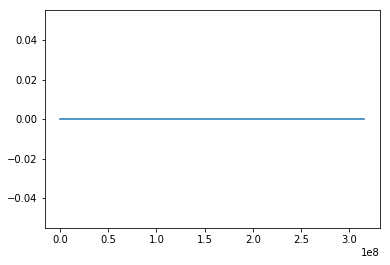

In [20]:
import matplotlib.pyplot as plt

psrs[0].make_ideal()
plt.plot(psrs[0].toas, psrs[0].residuals)
plt.show()

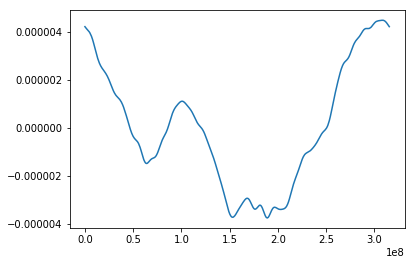

In [21]:
psrs[0].add_red_noise()
plt.plot(psrs[0].toas, psrs[0].residuals)
plt.show()

The properties of the injected noises are stored in the `noisedict` attribute of the `Pulsar` object and can be checked or modified at any time.

In [22]:
psrs[0].noisedict

{'J0724+7374_NUPPI_efac': 1.0,
 'J0724+7374_NUPPI_log10_tnequad': -8.0,
 'J0724+7374_NUPPI_log10_t2equad': -8.0,
 'J0724+7374_red_noise_log10_A': -13.222022136418861,
 'J0724+7374_red_noise_gamma': 3.3155419142943945,
 'J0724+7374_dm_gp_log10_A': -15.044799416383176,
 'J0724+7374_dm_gp_gamma': 2.083269801586817}

# Adding correlated noises

It possible to inject noises that are correlated between pulsars with the method `fakepta.correlated_noises.add_correlated_red_noise_gp` which generates a gaussian process `n(t)` just like the `fakepta.Pulsar.add_time_correlated_noise_gp` except this time, the `n(t)` is size of all concatenated TOAs of the whole array. In practice, there are too many TOAs per pulsars so this method is too slow. However, for low frequency signals, it is possible to downsample each pulsar to a fixed number of TOAs (ntoas=100), perform the draw, and interpolate the result to the actual TOAs to generate the desired signal with sufficient accuracy. Three correlation patterns are avaiable for injection : Hellings-Down, monopolar, dipolar.

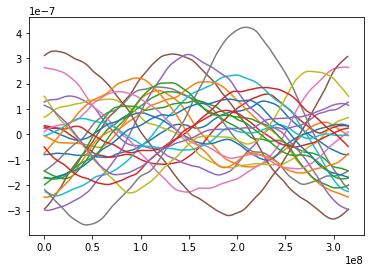

In [23]:
# Adding HD
for psr in psrs:
    psr.make_ideal()

add_correlated_red_noise_gp(psrs, log10_A=-15, gamma=13/3, orf='hd')

for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

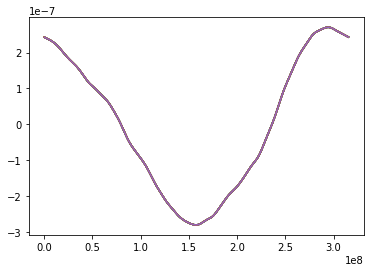

In [24]:
# Adding monopole
for psr in psrs:
    psr.make_ideal()

add_correlated_red_noise_gp(psrs, log10_A=-15, gamma=13/3, orf='monopole')

for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

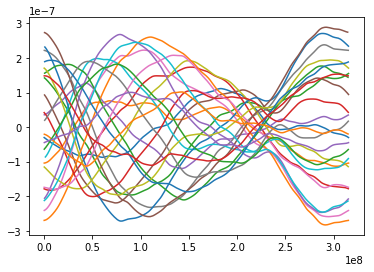

In [27]:
# Adding dipole
for psr in psrs:
    psr.make_ideal()

add_correlated_red_noise_gp(psrs, log10_A=-15, gamma=13/3, orf='dipole')

for psr in psrs:
    plt.plot(psr.toas, psr.residuals)
plt.show()

# Adding deterministic signals